# Vertex Cover Problem
Wikipedia: [Vertex cover](https://en.wikipedia.org/wiki/Vertex_cover)

In [1]:
# 問題設定
NUM_VER = 6
edges = [(0,1), (0,4), (0,5), (1,2), (1,3), (3,4), (4,5)]

# QUBOの作成
## PyQUBOの場合

In [2]:
from pyqubo import Array, Constraint, Placeholder, solve_qubo

In [3]:
# BINARY変数
x = Array.create('x', shape=NUM_VER, vartype='BINARY')

# QUBO形式で定式化
H_cover = Constraint(sum((1-x[u])*(1-x[v]) for (u, v) in edges), 'cover')
H_vertices = sum(x)
H = H_vertices + Placeholder('cover') * H_cover

# モデルをコンパイル
model = H.compile()

In [4]:
# 制約項のペナルティウェイト
param_cover = 1.0

In [5]:
# プレースホルダーと合わせてQUBOを作成
feed_dict = {'cover': param_cover}
qubo, offset = model.to_qubo(feed_dict=feed_dict)

## 従来の場合

In [6]:
# 係数行列
h = [0] * NUM_VER
J = {}
S = {}

for u in range(NUM_VER):
    h[u] = -2*param_cover + 1
    for v in range(u+1, NUM_VER):
        if (u,v) in edges:
            J[u,v] = param_cover
            S[u,v] = 1

In [7]:
print(h)
print(J)
print(S)

[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0]
{(0, 1): 1.0, (0, 4): 1.0, (0, 5): 1.0, (1, 2): 1.0, (1, 3): 1.0, (3, 4): 1.0, (4, 5): 1.0}
{(0, 1): 1, (0, 4): 1, (0, 5): 1, (1, 2): 1, (1, 3): 1, (3, 4): 1, (4, 5): 1}


# 最適化
## PyQUBOの場合

In [8]:
# PyQUBOのSAで解を探索する
raw_solution = solve_qubo(qubo)

# 得られた結果をデコードする
decoded_solution, broken, energy = model.decode_solution(raw_solution, vartype="BINARY", feed_dict=feed_dict)

In [9]:
print(decoded_solution)

{'x': {0: 1, 1: 1, 2: 0, 3: 0, 4: 1, 5: 0}}


In [10]:
print(broken)

{}


In [11]:
print(energy)

3.0


## D-Wave Ocean SDKの場合

In [12]:
from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite

sampler = EmbeddingComposite(DWaveSampler())
response = sampler.sample_qubo(qubo)

In [13]:
print(response.samples_matrix)

[[0 1 1 0 0 0]]


## 従来の場合(SAPI)

In [14]:
# はじめに、D-WaveのAPI(SAPI)に接続する
# 注：接続部のコードには認証コードが含まれるため省略している。
# 2つのメソッドを実行するだけで簡単に接続・ソルバー指定が完了する。

# Q行列をイジングに変換
# (h, J, ising_offset) = qubo_to_ising(Q)

# グラフ構造を取得
# A = get_hardware_adjacency(solver)

# ハミルトニアン埋め込み
# embeddings = find_embedding(S, A)
# [h0, j0, jc, emb] = embed_problem(h, J, embeddings, A)
# emb_j = j0.copy()
# emb_j.update(jc)

# ソルバーへ送信 (numreadsで実行回数を指定する)
# result = solve_ising(solver, h0, emb_j, auto_scale=True, num_reads=100)

# 結果の逆埋め込み
# answer = unembed_answer(result['solutions'], emb, 'minimize_energy', h, J)

# Pickleによる保存

In [15]:
import pickle

In [16]:
# モデルをコンパイル
model = H.compile()

# モデルをpickleで保存
with open('model.pickle', 'wb') as f:
    pickle.dump(model, f)

In [17]:
# pickleで保存したモデルを読み込む
with open('model.pickle', 'rb') as f:
    loaded_model = pickle.load(f)

# 正規化

In [18]:
# 各項を正規化する関数
def normalize(exp, vtype='SPIN'):
    if vtype != 'SPIN' and vtype != 'BINARY':  # 変数のタイプがイジング・QUBO表現でない場合、終了
        print("vtype must be 'SPIN' or 'BINARY'.")
        return
 
    model = exp.compile()
    if vtype == 'SPIN':
        compiled_h, compiled_J, offset = model.to_ising()
        norm = max(abs(max(compiled_h.values())),
                        abs(max(compiled_J.values())),
                        abs(min(compiled_h.values())),
                        abs(min(compiled_J.values())))

    else:
        compiled_qubo, offset = model.to_qubo()
        norm = max(abs(max(compiled_qubo.values())), abs(min(compiled_qubo.values())))

    # 絶対値が最大の係数で各成分を割ることで、[0,1]に正規化
    return exp / norm

In [19]:
# normalize関数の使用例(分かりやすくするため、変数で分けている)
exp = sum((1-x[u])*(1-x[v]) for (u,v) in edges)
normalized_exp = normalize(exp)
H_cover = Constraint(normalized_exp, 'cover')

In [20]:
H_cover

Const(cover, (((((Qbit(x[0])*Num(-1))+Num(1))*((Qbit(x[1])*Num(-1))+Num(1)))+(((Qbit(x[0])*Num(-1))+Num(1))*((Qbit(x[4])*Num(-1))+Num(1)))+(((Qbit(x[0])*Num(-1))+Num(1))*((Qbit(x[5])*Num(-1))+Num(1)))+(((Qbit(x[1])*Num(-1))+Num(1))*((Qbit(x[2])*Num(-1))+Num(1)))+(((Qbit(x[1])*Num(-1))+Num(1))*((Qbit(x[3])*Num(-1))+Num(1)))+(((Qbit(x[3])*Num(-1))+Num(1))*((Qbit(x[4])*Num(-1))+Num(1)))+(((Qbit(x[4])*Num(-1))+Num(1))*((Qbit(x[5])*Num(-1))+Num(1))))*Num(1.3333333333333333)))

# Sympyとの連携

In [21]:
from sympy import Symbol, Sum, init_printing
init_printing()
import pyqubo
import re

In [22]:
# 変数
x = Symbol('x_i')
i = Symbol('i')
n = Symbol('n')

# Sympyで数式を定義
H = (Sum(x, (i, 1, n)) -1)**2

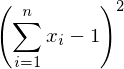

In [23]:
H

In [24]:
# Sympyの数式をPyQUBO用の文字列に変換する
def sympy2pyqubo(exp_sympy):
    str_sympy = exp_sympy

    # Sum -> sum
    str_sympy = str_sympy.replace('S', 's')

    # 総和の範囲(*,*,*)をfor文に置き換える
    str_sympy = \
    re.sub(',\s*[^sum]\(\s*(.+)\s*,\s*(.+)\s*,\s*(.+)\s*\)\)', \
        ' for \\1 in range(\\2, \\3))', str_sympy)

    # 変数をリストに置き換える
    str_sympy = \
    re.sub('(.+?)_(.+?)', '\\1[\\2]', str_sympy)

    return str_sympy

In [26]:
n = 10
x = pyqubo.Array.create("x_i", shape=n, vartype='SPIN')

str_H = str(H)
H = eval(sympy2pyqubo(str_H))
print(H)

((Spin(x_i[1])+Spin(x_i[2])+Spin(x_i[3])+Spin(x_i[4])+Spin(x_i[5])+Spin(x_i[6])+Spin(x_i[7])+Spin(x_i[8])+Spin(x_i[9])+Num(-1))*(Spin(x_i[1])+Spin(x_i[2])+Spin(x_i[3])+Spin(x_i[4])+Spin(x_i[5])+Spin(x_i[6])+Spin(x_i[7])+Spin(x_i[8])+Spin(x_i[9])+Num(-1)))


In [27]:
print(type(H))

<class 'pyqubo.core.express.Mul'>
